In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse

    Load file with all core specifications

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

In [4]:
lat = np.array([71.12038,70.30,77.17972,70.63491,70.65081,70.67700,70.63980,71.75926,71.49200,71.15495,70.86510])
lon = np.array([322.68364,315.00000,298.89026,324.18001,322.52121,321.21300,320.38222,324.14947,324.11877,324.16227,324.16187])
elev = np.array([3172,2410,1880,3092,3138,3072,3018,3087,3092,3098,3102])
T10m = -np.array([30.40,22.30,24.29,29.41,29.77,29.07,28.30,30.37,30.42,30.10,29.59])
T20m = -np.array([30.16,0,24.35,29.41,29.48,28.54,27.89,30.41,30.36,30.01,29.53])
coreLength = np.array([404.0,398.0,100.1,128.6,105.6,24.9,100.1,77.8,25.7,70.8,26.2])
drillYr = np.array([1974,1973,1977,1985,1984,1984,1984,1985,1985,1985,1985])

CoresSpecs['lat'] = lat
CoresSpecs['lon'] = lon
CoresSpecs['elev'] = elev
CoresSpecs['T10m'] = T10m
CoresSpecs['T20m'] = T20m
CoresSpecs['coreLength'] = coreLength
CoresSpecs['drillYr'] = drillYr

#print(CoresSpecs.to_latex(index=False))

CoresSpecs2 = CoresSpecs.drop('z0', axis=1)
CoresSpecs2.drop('dens0',axis=1)

CoresSpecs2 = CoresSpecs2[['CoreName','drillYr', 'coreLength', 'lat', 'lon','elev','dLaki', 'dTamb', 'Accum0', 'T0', 'T10m', 'T20m']]
#CoresSpecs2 = CoresSpecs2[[]]
CoresSpecs2.to_csv('/home/thea/MesterTesen/Data/CoreSpecs2.txt', index=None, sep=',')
print(CoresSpecs2.to_latex(index=False))

\begin{tabular}{lrrrrrllrrrr}
\toprule
    CoreName &  drillYr &  coreLength &       lat &        lon &  elev &  dLaki &  dTamb &  Accum0 &     T0 &   T10m &   T20m \\
\midrule
       Crete &     1974 &       404.0 &  71.12038 &  322.68364 &  3172 &  74.75 &  64.70 &   0.280 & -30.40 & -30.40 & -30.16 \\
     Milcent &     1973 &       398.0 &  70.30000 &  315.00000 &  2410 &        &        &   0.530 & -22.30 & -22.30 &  -0.00 \\
 CampCentury &     1977 &       100.1 &  77.17972 &  298.89026 &  1880 &  91.50 &  78.50 &   0.380 & -24.29 & -24.29 & -24.35 \\
       SiteA &     1985 &       128.6 &  70.63491 &  324.18001 &  3092 &  80.85 &  70.90 &   0.307 & -29.41 & -29.41 & -29.41 \\
       SiteB &     1984 &       105.6 &  70.65081 &  322.52121 &  3138 &  83.70 &  73.00 &   0.327 & -29.77 & -29.77 & -29.48 \\
       SiteC &     1984 &        24.9 &  70.67700 &  321.21300 &  3072 &        &        &   0.340 & -29.10 & -29.07 & -28.54 \\
       SiteD &     1984 &       100.1 &  70.63980

    Choose site and get specifications from given site.

In [5]:
coreNames = CoresSpecs['CoreName']

site = 'SiteE'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])


    Get profiles available

In [6]:
site_Dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+ site + 'DepthDens_w_Models.txt', '\t')
site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')
site_ECM = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetECM/'+ site + '_ECM.txt', ',') 
site_d18O =  pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+ site + '_det.txt', ',')

    Rename arrays

In [7]:
    # Define density measurements: raw, model and fudged model. Define btw. Laki and Tamb.
depthRho = site_Dens['depth']
rhoMeas = site_Dens['rhoMeas']
HLmodel = site_Dens['HLmodel']
HLmodelOpti = site_Dens['HLmodelOpti']
depthRho_LT = depthRho[(depthRho >= dTamb) & (depthRho <= dLaki)]
rhoMeas_LT = rhoMeas[(depthRho >= dTamb) & (depthRho <= dLaki)]
HLmodel_LT = HLmodel[(depthRho >= dTamb) & (depthRho <= dLaki)]
HLmodelOpti_LT =HLmodelOpti[(depthRho >= dTamb) & (depthRho <= dLaki)]

    # Define diffusion length measurements: o18, o17 and D. Define btw. Laki and Tamb.
depthDiff = site_Diff['Depth']
sigma_D = site_Diff['sigma_D']
sigma_o18 = site_Diff['sigma_o18']
sigma_o17 = site_Diff['sigma_o17']
depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o18_LT = sigma_o18[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o17_LT = sigma_o17[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_D_LT = sigma_D[(depthDiff >= dTamb) & (depthDiff <= dLaki)]

    # Define ECM data. Define btw. Laki and Tamb.
depthECM = site_ECM['depth']
ECM = site_ECM['ECM']
depthECM_LT = depthECM[(depthECM >= dTamb) & (depthECM <= dLaki)]
ECM_LT = ECM[(depthECM >= dTamb) & (depthECM <= dLaki)]

    # Define d18O details data. Define btw. Laki and Tamb.
depth = site_d18O['depth'][1:]
d18O = site_d18O['d18O'][1:]
depth_LT = site_d18O['depth'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]
d18O_LT = site_d18O['d18O'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]


    Plot depth/density profile

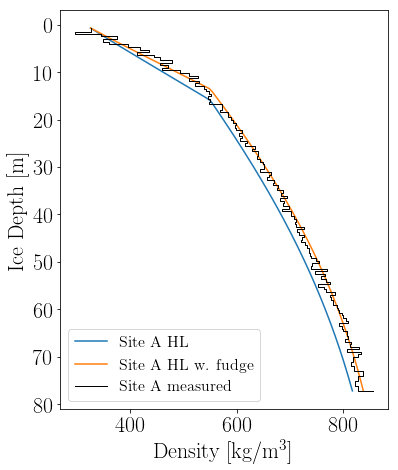

In [8]:
fig1, ax1 = plt.subplots(figsize=(6,7))

ax1.set(xlabel='Density [kg/m$^3$]', ylabel='Ice Depth [m]')
ax1.invert_yaxis()
ax1.plot(HLmodel*1000, depthRho, label='Site A HL')
ax1.plot(HLmodelOpti*1000, depthRho, label=f'Site A HL w. fudge')#\nf0 = {f0:.2f} f1 = {f1:.2f}')

ax1.step(rhoMeas, depthRho,'k',lw=1,label='Site A measured')
ax1.legend(fontsize=16)
fig1.tight_layout()
if saveFigs:
    fig1.savefig('../../WrittenWork/Figures/' + site + '_DensProfile_wHL.jpg')

    Plot depth/diffusion length profile

Max sigma, theoretically: 0.078
Min sigma, theoretically: 0.075


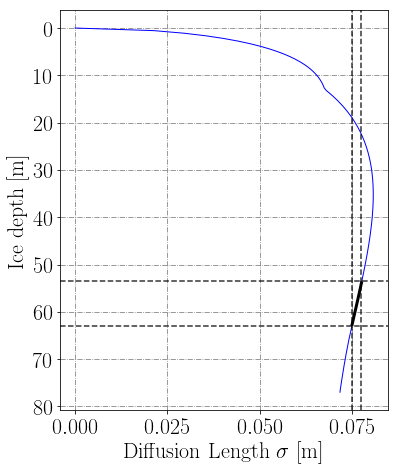

In [9]:
figDiff, axDiff = plt.subplots(figsize=(6,7))

axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]')
axDiff.invert_yaxis()
axDiff.plot(sigma_o18,depthDiff, 'b', lw=1)
axDiff.plot(sigma_o18_LT,depthDiff_LT, 'k', lw=3)
axDiff.axhline(y = dTamb, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axhline(y = dLaki, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_o18_LT.values[0], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_o18_LT.values[-1], alpha=0.8, color='k', ls='--', lw=1.5)

axDiff.grid(True, color='grey',ls='-.')
figDiff.tight_layout()
#if saveFigs:
#    figDiff.savefig('../../WrittenWork/NovemberPresentation/SiteA_DiffLen.jpg')
sigmaMax_theo = sigma_o18_LT.max()
sigmaMin_theo = sigma_o18_LT.min()
print(f'Max sigma, theoretically: {sigma_o18_LT.max():.3f}')
print(f'Min sigma, theoretically: {sigma_o18_LT.min():.3f}')

if saveFigs:
    figDiff.savefig('../../WrittenWork/Figures/' + site + '_DiffProfile.jpg')

    Plot volcanic + d18O data together

In [10]:
d1 = dTamb - 0.7
d2 = dLaki + 0.7

depthECM_LTX = depthECM[(depthECM >= d1) & (depthECM <= d2)]
ECM_LTX = ECM[(depthECM >= d1) & (depthECM <= d2)]

    # Define d18O details data. Define btw. Laki and Tamb.
depth_LTX = site_d18O['depth'][(site_d18O['depth'] >= d1) & (site_d18O['depth'] <= d2)]
d18O_LTX = site_d18O['d18O'][(site_d18O['depth'] >= d1) & (site_d18O['depth'] <= d2)]


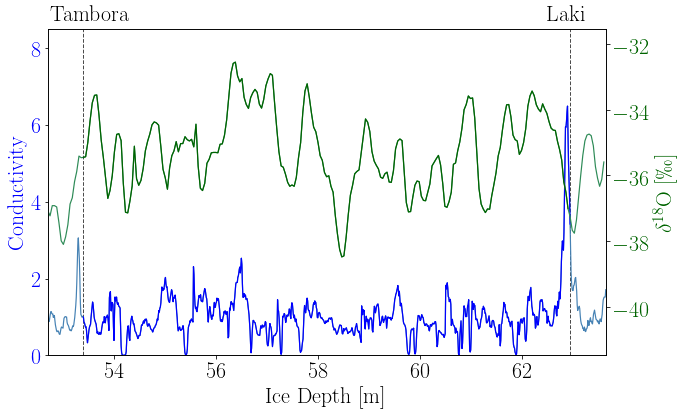

In [11]:
figDEP2, axDEP2 = plt.subplots(figsize=(10,6))
axDEP2.axvline(x=dTamb, color='k', ls='--', alpha=0.7, lw=1)
axDEP2.axvline(x=dLaki, color='k', ls='--', alpha=0.7, lw=1)
axDEP2.text(dTamb-0.65,max(ECM_LTX)+2+0.2, 'Tambora')
axDEP2.text(dLaki-0.45,max(ECM_LTX)+2+0.2, 'Laki')

axDEP2.set(ylim=(0,max(ECM_LTX)+2),xlim=(min(depthECM_LTX),max(depthECM_LTX)), xlabel='Ice Depth [m]')
axDEP2.set_ylabel('Conductivity', color='blue')
axDEP2.tick_params(axis='y', labelcolor='blue')
axDEP2.plot(depthECM_LTX, ECM_LTX, lw=1.2, color='steelblue')
axDEP2.plot(depthECM_LT, ECM_LT, lw=1.2, color='blue')


axDEP2_2 = axDEP2.twinx()

axDEP2_2.set(ylim=(min(d18O_LTX)-3,max(d18O_LTX)+1))
axDEP2_2.set_ylabel('$\delta^{18}$O [\permil]', color='darkgreen')
axDEP2_2.tick_params(axis='y', labelcolor='darkgreen')
axDEP2_2.plot(depth_LTX, d18O_LTX, lw=1.2, color='seagreen')
axDEP2_2.plot(depth_LT,d18O_LT, lw=1.2, color='darkgreen')


if saveFigs:
    figDEP2.savefig('../../WrittenWork/Figures/' + site + '_ECMd18O_combo.jpg')

    Plot insert raw data

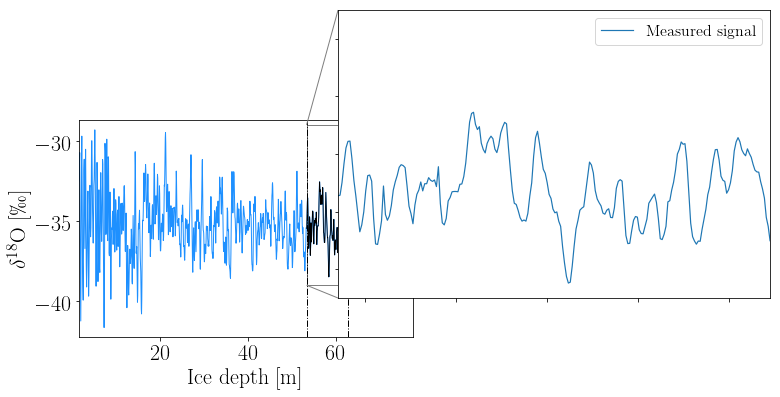

In [12]:
fig_Iso, ax_Iso = plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size': 22})

ax_Iso.plot(depth, d18O,'dodgerblue',lw=1)
ax_Iso.plot(depth_LT, d18O_LT,'k',lw=0.8)
ax_Iso.set(xlim=(depth.min(), depth.max()), xlabel='Ice depth [m]',ylabel='$\delta ^{18}$O [\permil]')
ax_Iso.axvline(x=dTamb,color='k',lw=1, ls='-.')
ax_Iso.axvline(x=dLaki,color='k',lw=1, ls='-.')

x1 = depth_LT.min()
x2 = depth_LT.max()
y1 = -39
y2 = -29

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = inset_axes(ax_Iso, 6,4, loc=2, bbox_to_anchor=(0.7,0.3,1,1), bbox_transform=ax_Iso.figure.transFigure)#loc=5) # zoom = 2
axins.plot(depth_LT, d18O_LT, label='Measured signal', lw=1.2)
#axins.plot(depth_LT_int, d18O_LT_int,color='k',lw=1, alpha=0.8, linestyle='--', label='Spline interp., $\Delta =$ '+f'{Delta:.3f}')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.legend(fontsize=16)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax_Iso, axins, loc1=2, loc2=3, fc="none", ec="0.5")

#plt.draw()
#plt.show()

if saveFigs:
    fig_Iso.savefig('../../WrittenWork/Figures/' + site + '_d18OInsert.jpg', bbox_inches = 'tight')


    Plot raw and interpolated data

In [13]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    print(min(diff))
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta


depth_LT_int, d18O_LT_int, Delta = interpCores(np.asarray(depth_LT)[0], np.asarray(depth_LT)[-1], depth_LT, d18O_LT)

0.04099999999999682


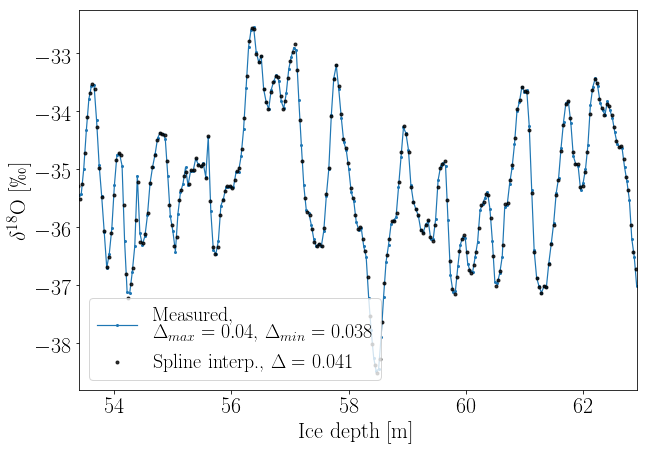

In [14]:
fig_IsoLT, ax_IsoLT = plt.subplots(figsize=(10,7))

ax_IsoLT.plot(depth_LT, d18O_LT,marker='.', markersize=4,ls='-',lw=1.2, label='Measured,\n$\Delta_{max}=0.04$, $\Delta_{min}=0.038$')
ax_IsoLT.plot(depth_LT_int, d18O_LT_int, '.', color='k',alpha=0.8, label='Spline interp., $\Delta =$ '+f'{Delta:.3f}')
ax_IsoLT.set(xlim=(depth_LT.min(),depth_LT.max()), xlabel='Ice depth [m]',ylabel='$\delta ^{18}$O [\permil]')
ax_IsoLT.legend(fontsize=20)

if saveFigs:
    fig_IsoLT.savefig('../../WrittenWork/Figures/' + site + '_d18OLT_Interp.jpg')

    Plot raw spectral transform (DCT, FFT, MEM)

Diff. len., fit [cm]: 7.784


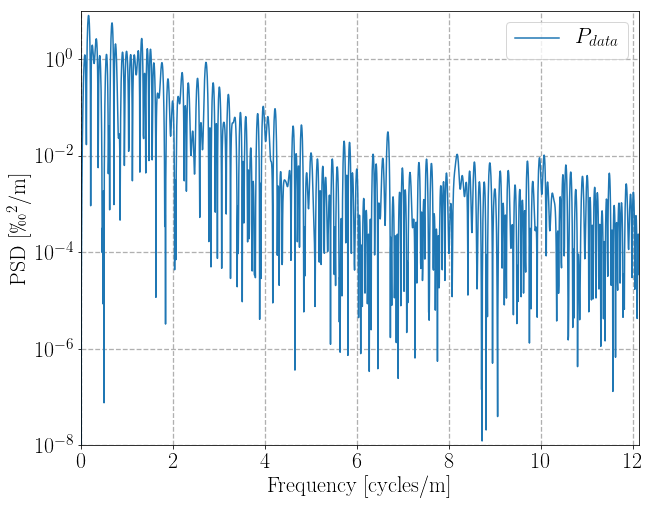

In [15]:
from Decon import SpectralDecon

decon_inst = SpectralDecon(depth_LT_int, d18O_LT_int, 2000)

w, P, Pnoise, Psignal, P_fit, opt_fit_dict, params_fit, fit_func_val, fit_dict = decon_inst.SpectralFit(printFitParams=False)

fig_dct, ax_dct = plt.subplots(figsize=(10,8))
ax_dct.semilogy(w,P, label='$P_{data}$')
ax_dct.grid(linestyle='--',lw=1.3, which='both')
ax_dct.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [\permil$^2$/m]', xlabel='Frequency [cycles/m]')
ax_dct.set_ylim((1e-8,10))
ax_dct.legend()

sigma_fit = opt_fit_dict['s_tot2_fit']

if saveFigs:
    fig_dct.savefig('../../WrittenWork/Figures/' + site + '_DCT_PSD_raw.jpg')

    Plot fits to raw pectrum.

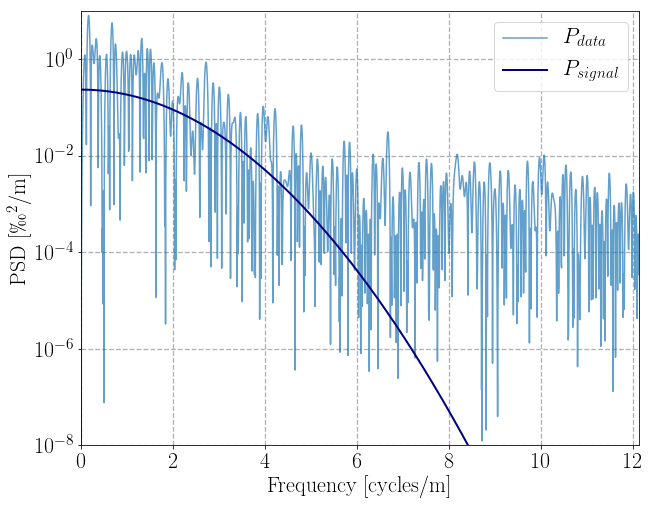

In [16]:
fig_PSDsig, ax_PSDsig = plt.subplots(figsize=(10,8))

ax_PSDsig.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDsig.semilogy(w, Psignal, label='$P_{signal}$',lw=2, color='navy')
ax_PSDsig.grid(linestyle='--',lw=1.3, which='both')
ax_PSDsig.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [\permil$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDsig.set_ylim((1e-8,10))
ax_PSDsig.legend()

if saveFigs:
    fig_PSDsig.savefig('../../WrittenWork/Figures/' + site + '_PSD_sig.jpg')


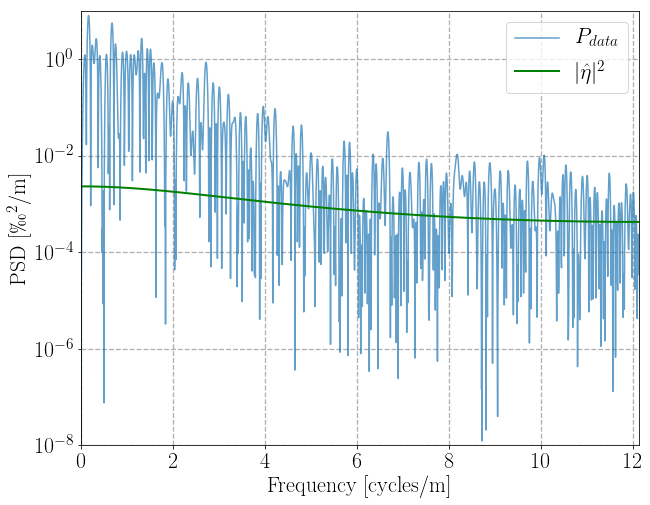

In [17]:
fig_PSDnoi, ax_PSDnoi = plt.subplots(figsize=(10,8))

ax_PSDnoi.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDnoi.semilogy(w, Pnoise, label='$|\hat{\eta}|^2$', lw=2,color='green')
ax_PSDnoi.grid(linestyle='--',lw=1.3, which='both')
ax_PSDnoi.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [\permil$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDnoi.set_ylim((1e-8,10))
ax_PSDnoi.legend()

if saveFigs:
    fig_PSDnoi.savefig('../../WrittenWork/Figures/' + site + '_PSD_noise.jpg')

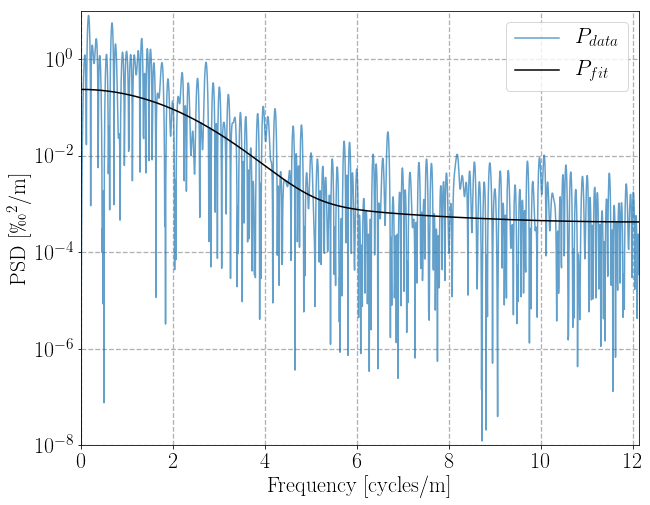

In [18]:
fig_PSDfit, ax_PSDfit = plt.subplots(figsize=(10,8))

ax_PSDfit.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDfit.semilogy(w, P_fit, color='k', label='$P_{fit}$')
ax_PSDfit.grid(linestyle='--',lw=1.3, which='both')
ax_PSDfit.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [\permil$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDfit.set_ylim((1e-8,10))
ax_PSDfit.legend()

if saveFigs:
    fig_PSDfit.savefig('../../WrittenWork/Figures/' + site + '_PSD_fit.jpg')

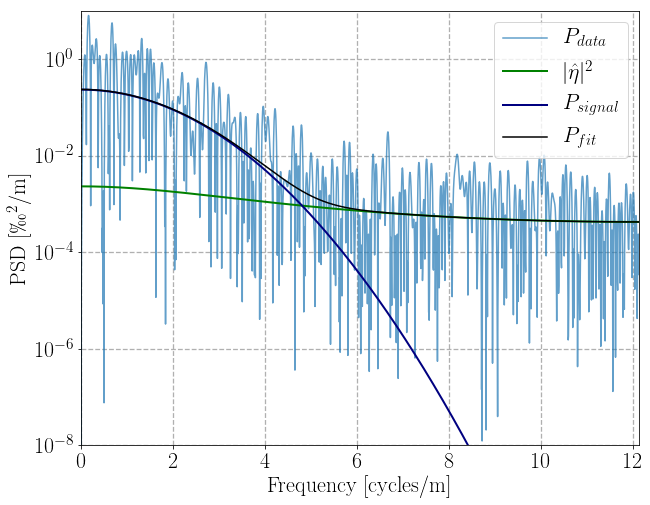

In [19]:
fig_PSDall, ax_PSDall = plt.subplots(figsize=(10,8))

ax_PSDall.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDall.semilogy(w, Pnoise, label='$|\hat{\eta}|^2$', lw=2,color='green')
ax_PSDall.semilogy(w, Psignal, label='$P_{signal}$',lw=2, color='navy')
ax_PSDall.semilogy(w, P_fit, color='k', label='$P_{fit}$')
ax_PSDall.grid(linestyle='--',lw=1.3, which='both')
ax_PSDall.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [\permil$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDall.set_ylim((1e-8,10))
ax_PSDall.legend()

if saveFigs:
    fig_PSDall.savefig('../../WrittenWork/Figures/' + site + '_PSD_all.jpg')

    Plot created filters

In [20]:
sigma_min = 5/100
sigma_max = 8.5/100

sigma_in = np.linspace(sigma_min-0.01,sigma_max,6)
sigma_in

array([0.04 , 0.049, 0.058, 0.067, 0.076, 0.085])

In [21]:
c = []

for i in range(len(sigma_in)):
    c.append(decon_inst.Filters(sigma=sigma_in[i]))


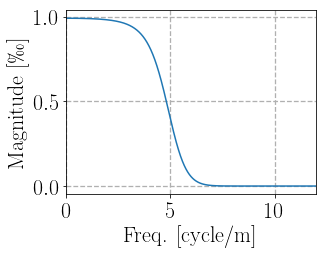

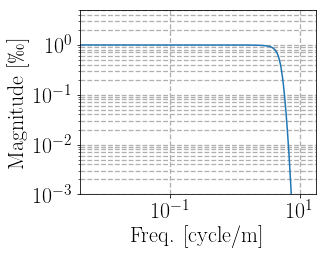

In [22]:
figWiener0, axWiener0 = plt.subplots(figsize=(5,4))

axWiener0.plot(c[0][0],c[0][1])
axWiener0.grid(linestyle='--',lw=1.3, which='both')
axWiener0.set(xlim=(0,12), xlabel='Freq. [cycle/m]', ylabel='Magnitude [\permil]')
figWiener0.tight_layout()


figWiener1, axWiener1 = plt.subplots(figsize=(5,4))

axWiener1.loglog(c[0][0],c[0][1])
axWiener1.grid(linestyle='--',lw=1.3, which='both')
axWiener1.set(ylim=(1e-3,5), xlabel='Freq. [cycle/m]', ylabel='Magnitude [\permil]')

figWiener1.tight_layout()


if saveFigs:
    figWiener0.savefig('../../WrittenWork/Figures/' + site + '_WienerFilter.jpg')
    figWiener1.savefig('../../WrittenWork/Figures/' + site + '_WienerFilter_loglog.jpg')

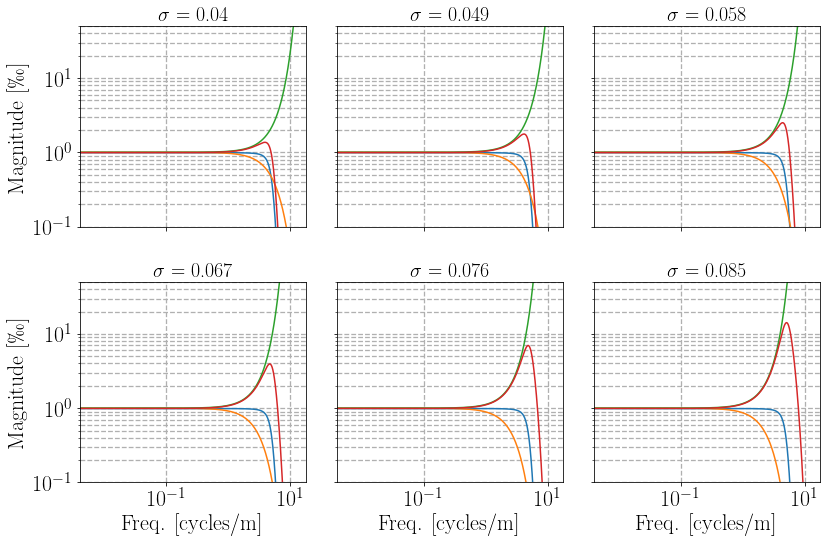

In [23]:
fig, axes = plt.subplots(2,3,figsize=(12,8), sharey=True, sharex=True)
plt.rcParams.update({'font.size': 22})

axes.titlesize:'x-large'
axes.labelsize:'large'
#plt.rcParams.update({'title.size': 18})
for i, ax in zip(range(len(sigma_in)), axes.flatten()):
    ax.grid(linestyle='--',lw=1.3, which='both')
    ax.loglog(c[i][0], c[i][1])
    ax.loglog(c[i][0], c[i][2])
    ax.loglog(c[i][0], c[i][2]**(-1))
    ax.loglog(c[i][0], c[i][3])
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=20)
    ax.set(ylim=(1e-1,50))#, xlabel='Freq. [cycles/m]', ylabel='Magnitude [\permil]')
axes.flatten()[0].set(ylabel='Magnitude [\permil]'); axes.flatten()[3].set(ylabel='Magnitude [\permil]', xlabel='Freq. [cycles/m]');
axes.flatten()[3].set(xlabel='Freq. [cycles/m]'); axes.flatten()[4].set(xlabel='Freq. [cycles/m]'); 
axes.flatten()[5].set(xlabel='Freq. [cycles/m]');# axes.flatten()[9].set(xlabel='Freq. [cycles/m]'); 

#ax.legend(labels= ['$\phi$', '$M$', '$M^{-1}$', '$R = \phi \cdot M^{-1}$'],bbox_to_anchor=(1,1.4), fontsize=16)
fig.tight_layout()

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + site + '_filtersEx.jpg')

    Create instance of back diffusion and make estimates of diffusion length

# NOTE: Make example of final filters as well as final deconvolutions!!!

In [24]:
inst = BackDiffuse(site, site_d18O, CoresSpecs, dTamb, dLaki, 32, diffLenData=site_Diff[['Depth','sigma_o18']], densData=site_Dens)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks = inst.backDiffused()

Starting sigma: 6.50 [cm]
34
34
34
34
34
33
33
33
33
33
33
32
32
32
32
32
32
33
Final sigma: 5.99 [cm]
Final # of peaks: 32


    Plot original data, back diffused data and peak estimations

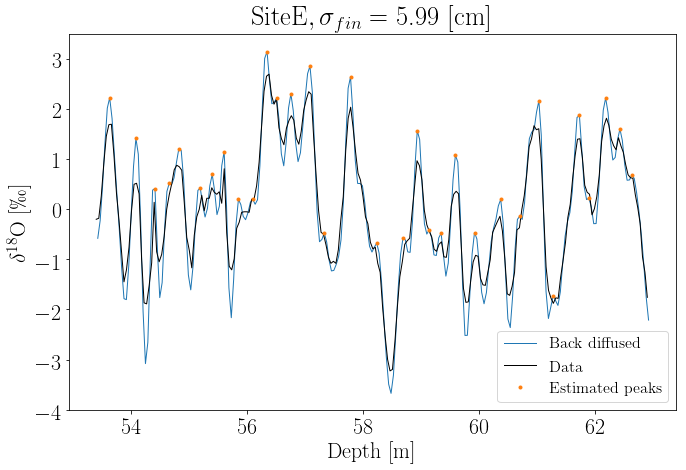

In [25]:

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth1, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth1[peaks], data[peaks],'.',lw=1, label='Estimated peaks')
ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=site+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig(site+ '_peaks.jpg')

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + site + '_BackDiffused_Y32.jpg')

array([0.45261071, 0.32917143, 0.24687857, 0.16458571, 0.37031786,
       0.20573214, 0.20573214, 0.24687857, 0.24687857, 0.24687857,
       0.16458571, 0.24687857, 0.32917143, 0.24687857, 0.45261071,
       0.45261071, 0.45261071, 0.24687857, 0.20573214, 0.20573214,
       0.24687857, 0.32917143, 0.45261071, 0.32917143, 0.32917143,
       0.24687857, 0.45261071, 0.16458571, 0.288025  , 0.24687857,
       0.20573214])

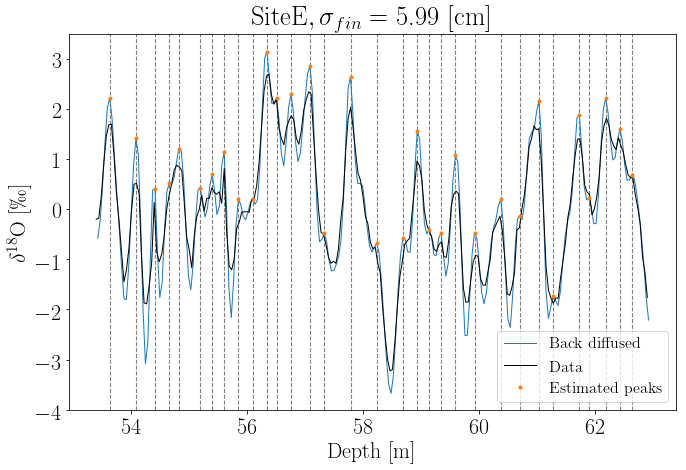

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(len(peaks)):
    ax.axvline(x=depth1[peaks[i]], color='k', lw=1.1, ls='--', alpha=0.5)
    
ax.plot(depth1, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth1[peaks], data[peaks],'.',lw=1, label='Estimated peaks')

ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=site+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig(site+ '_peaks.jpg')
np.diff(depth1[peaks])

    Plot best sigma - from peak detection and theoretical.

In [27]:
print(f'Max theoretical sigma: {sigmaMax_theo:.3f}')
print(f'Min theoretical sigma: {sigmaMin_theo:.3f}')
print(f'Fitted estimated sigma: {sigma_fit:.3f}')
print(f'Final optimized sigma: {diffLen:.3f}')

Max theoretical sigma: 0.078
Min theoretical sigma: 0.075
Fitted estimated sigma: 0.078
Final optimized sigma: 0.060


In [28]:
depthMax, dataMax = decon_inst.deconvolve(sigmaMax_theo)
depthMin, dataMin = decon_inst.deconvolve(sigmaMin_theo)
depthFit, dataFit = decon_inst.deconvolve(sigma_fit)
depthFin, dataFin = decon_inst.deconvolve(diffLen)

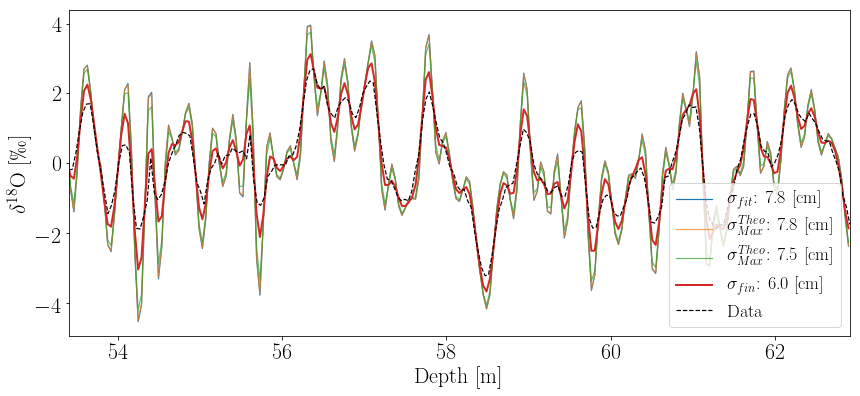

In [29]:
figAllSigma, axAllSigma = plt.subplots(figsize=(14,6))

axAllSigma.plot(depthFit, dataFit, label= '$\sigma_{fit}$'+f': {sigma_fit*100:.1f} [cm]',lw=1.2)
axAllSigma.plot(depthMax, dataMax, label= '$\sigma_{Max}^{Theo}$' + f': {sigmaMax_theo*100:.1f} [cm]', alpha=0.7,lw=1.2)
axAllSigma.plot(depthMin, dataMin, label= '$\sigma_{Max}^{Theo}$' + f': {sigmaMin_theo*100:.1f} [cm]', alpha=0.7,lw=1.2)
axAllSigma.plot(depthFin, dataFin, label= '$\sigma_{fin}$' + f': {diffLen*100:.1f} [cm]',lw=2)
axAllSigma.plot(depth_LT, d18O_LT-np.mean(d18O_LT), color='k', ls='--',lw=1.2, label='Data')
axAllSigma.set(xlim=(depth_LT.min(),depth_LT.max()), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
axAllSigma.legend(fontsize=18)

if saveFigs:
    figAllSigma.savefig('../../WrittenWork/Figures/' + site + '_BackDiffused_AllSigmaEst.jpg')

In [30]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in, Delta_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = Delta_in
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta

In [73]:
dhat, xhat, Delta = interpCores(depthFin.min(), depthFin.max(), pd.Series(depthFin), pd.Series(dataFin), 0.005)

In [74]:
from scipy import signal

peaks1 = signal.find_peaks(dataFin)[0]
peaks_interp = signal.find_peaks(xhat)[0]



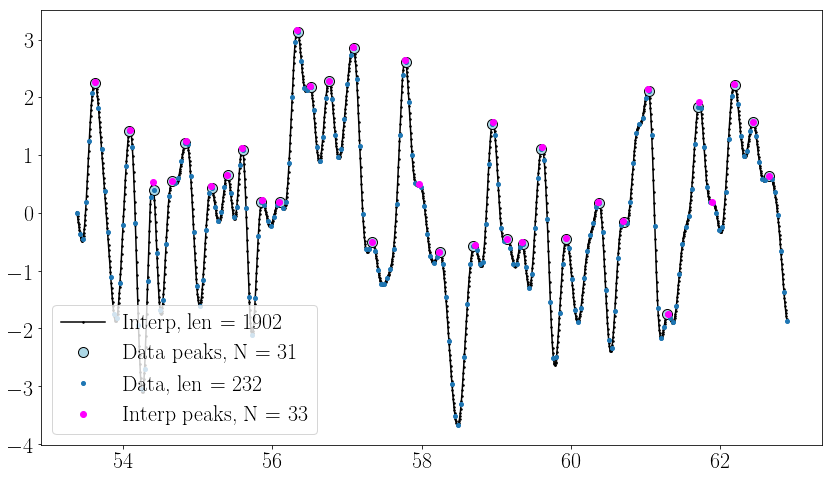

In [77]:
figInterp2, axInterp2 = plt.subplots(figsize=(14,8))

axInterp2.plot(dhat,xhat, '-', marker='.', ms=3, color='k',label=f'Interp, len = {len(dhat)}')
axInterp2.plot(depthFin[peaks1], dataFin[peaks1], 'o', ms=10, markeredgecolor='k', color='lightblue', label=f'Data peaks, N = {len(dataFin[peaks1])}')


axInterp2.plot(depthFin, dataFin,'o', ms=4, label=f'Data, len = {len(depthFin)}')
axInterp2.plot(dhat[peaks_interp], xhat[peaks_interp], 'o', ms=6, color='magenta', label=f'Interp peaks, N = {len(xhat[peaks_interp])}')



axInterp2.legend()

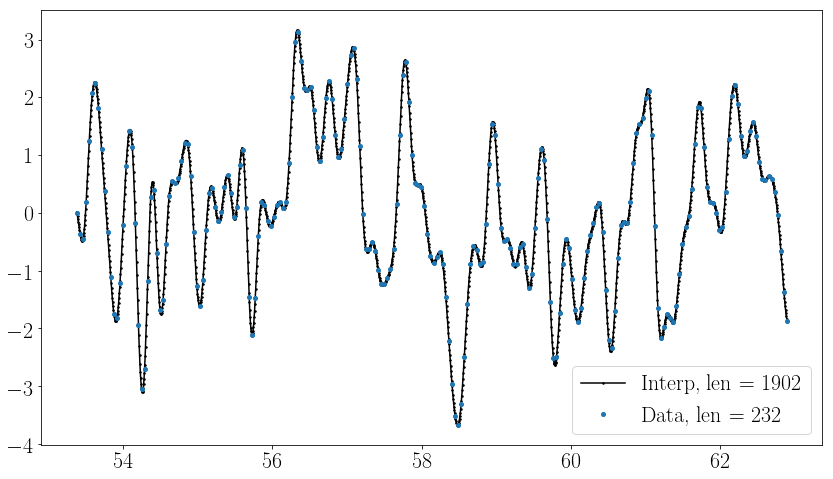

In [86]:
figInterp2, axInterp2 = plt.subplots(figsize=(14,8))

axInterp2.plot(dhat,xhat, '-', marker='.', ms=3, color='k',label=f'Interp, len = {len(dhat)}')
#axInterp2.plot(depthFin[peaks1], dataFin[peaks1], 'o', ms=10, markeredgecolor='k', color='lightblue', label=f'Data peaks, N = {len(dataFin[peaks1])}')


axInterp2.plot(depthFin, dataFin,'o', ms=4, label=f'Data, len = {len(depthFin)}')
#axInterp2.plot(dhat[peaks_interp], xhat[peaks_interp], 'o', ms=6, color='magenta', label=f'Interp peaks, N = {len(xhat[peaks_interp])}')



axInterp2.legend()